# Machine Learning (CS-433)
## Class Project 1
Simon Canales, Jordan Willemin, Claudio Loureiro

In [59]:
import numpy as np

from proj1_helpers import *
from implementations import *
from utils import *

# Plot libraries
import matplotlib
import matplotlib.pyplot as plt

In [60]:
training_pred, training_data, ids_tr = load_csv_data("../data/train.csv")
testing_pred, testing_data, ids_te = load_csv_data("../data/test.csv")

# Preprocessing

In [65]:
def adjust_wrong_data(training_data, y, wrongValue, testing_data = []):
    #Assign the mean value of the uncorrupted data of a feature to the corrupted data of this feature.
    #If training data, then the corrupted data take the mean value of the uncorrupted training data of the same class.
    #If testing data, then the corrupted data take the mean value of all the uncorrpted training data of this feature.
    
    if len(testing_data) == 0:
        for i in range(np.shape(training_data)[1]):
            feature = training_data[:,i] 
            feature_class_1 = feature[y==-1]
            feature_class_1_clean = feature_class_1[feature_class_1!=wrongValue]
            feature_mean_1 = np.mean(feature_class_1_clean)
            feature_class_2 = feature[y==1]
            feature_mean_2 = np.mean(feature_class_2[feature_class_2!=wrongValue])
            for j in range(np.shape(training_data)[0]):
                if y[j] == -1 and training_data[j,i] == wrongValue:
                    training_data[j,i] = feature_mean_1
                if y[j] == 1 and training_data[j,i] == wrongValue:
                    training_data[j,i] = feature_mean_2
        return training_data
    
    else:
        for i in range(np.shape(training_data)[1]):
            feature = training_data[:,i]
            feature_clean = feature[feature!=wrongValue]
            feature_mean = np.mean(feature_clean)
            for j in range(np.shape(testing_data)[0]):
                if testing_data[j,i] == wrongValue:
                    testing_data[j,i] = feature_mean
        return testing_data



In [66]:
wrong_value = -999
training_data = adjust_wrong_data(training_data, training_pred, wrong_value)
testing_data = adjust_wrong_data(training_data, training_pred, wrong_value, testing_data)

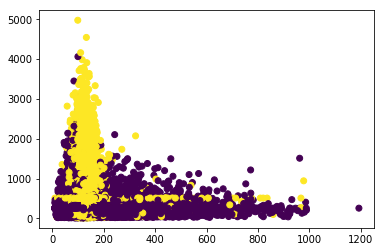

In [67]:
x1 = training_data[:,0]
x2 = training_data[:,5]

plt.scatter(x1,x2, c = training_pred)
plt.show()

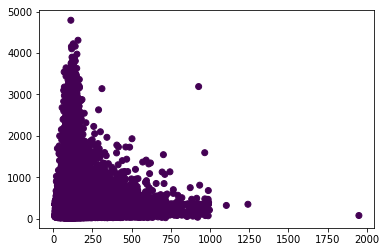

In [68]:
x1 = testing_data[:,0]
x2 = testing_data[:,5]

plt.scatter(x1,x2, c = testing_pred)
plt.show()

# Least Squares Gradient Descent

In [6]:
tx = build_poly(training_data, 2)
initial_w = np.zeros(tx.shape[1])
max_iters = 10
gamma = 0.01

k_fold = 4
indexes_te, indexes_tr = get_split_indexes(training_data, training_pred, k_fold)
mse_tr_mean, mse_te_mean, rmse_tr_mean, rmse_te_mean, accuracy = cross_validation(least_squares_GD, 
                                                                                  compute_mse, tx, training_pred, indexes_te, 
                                                                                  indexes_tr, k_fold, True, 
                                                                                  (initial_w, max_iters, gamma))

print('Mse: ', format(mse_te_mean))
print('Rmse: ', format(rmse_te_mean))
print('Accuracy: ', format(accuracy))

Mse:  0.35480318404888356
Rmse:  0.8423813673733336
Accuracy:  0.8703040000000002
